In [1]:
import os
import pickle
import sys

from data_workorders import WorkOrders

__version__ = "v0.0.19"

#from data_workorders import WorkOrders

In [2]:
import pandas as pd
import numpy as np
import datetime
from HX_vis import PlotGridBatch
from HX_stats import HistData
from settings import wpiSettings, wpiImageSettings, riaSettings
import math
from HX_sml import SML_Reg


In [3]:
import matplotlib.pyplot as plt
import os, sys
import itertools
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, FeatureUnion


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
#from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [7]:
dataDir = os.path.join("../2020 01-04/")
#dataDir = os.path.join("../2019 09-12")
pklDir = os.path.join(dataDir, "pkl")
with open(os.path.join(pklDir, "raw data.pkl"), "rb") as fin:
    binTrackData, wpiDataDict, wpiImgData, riaDataLs = pd.read_pickle(fin) #pickle.load(fin)

wodatasets = WorkOrders(pklDir=pklDir)
#print(binTrackData)



# <font color='red'>STEP 1: Data Exploration begins here </font>
#### There are a few considerations or information about data we have. We have wpi data, wpiImg data and ria data for ~700 workorders. For each workorder, information is as follows:

* Each row in wpiImg data corresponds to 1 potato as an entity. Hence number of rows = number of potatoes.
* Each row in ria data corresponds to 1 chip as an entity. Hence, number of rows = number of chips.
* However, in wpi data, there are 131 bins, and each bin reflects to 1 type of length or width. For example, for bin=64, Length is 64 and number of potatoes having  length~64 is assigned under 'length'. Hence summing up the length column or width column in wpi data should give the total number of potatoes in respective work order.
* wpi is in the unit mm, whereas wpiImg and ria data is in unit inches. 
* 2.5 inches ~= 63.5mm which is the threshold that we are chasing in this project.
* Each truckload will have all the varieties/types/sizes of potato.
* Each truckload will produce multiple sizes of chips including length <2.5 inches to >2.5 inches.
* Considering the consensus of population of potatoes in a truckload we can predict probabilities or %ages of  size of chips that can be produced more in number.
* We have got data from ~700 truckloads from 3 months.
* Each truckload sums up into 1 data point in the data we have.




#### Below few steps helps to explore how much missing values we have in our data.

## Plots below explore how much missing data we have. Its plotting number of datapoints for each workorder for wpiImage and Ria.

numpy.ndarray

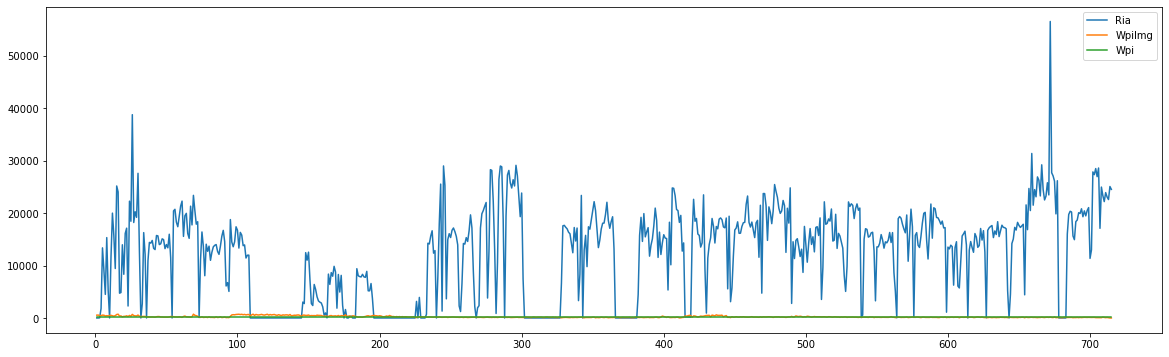

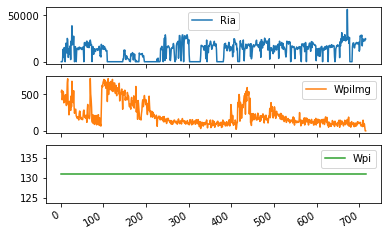

In [8]:
#Plot From each workorder corresponding data, get the number of datapoints in ria, wpiImg, and wpi
import matplotlib.pyplot as plt 
DataPointsNum=[]
cols=["Ria","WpiImg","Wpi"]
wo=0
index=[]
for e in wodatasets.wodataLs:
    wo=wo+1
    index.append(wo)
    DataPointsNum.append([e.ria.shape[0],e.wpiImg.shape[0],e.wpi.shape[0]])

#dataPoints = pd.DataFrame(DataPointsNum, columns=cols)
dataPoints = pd.DataFrame(DataPointsNum, index=index, columns=cols)

dataPoints.plot(figsize=(20,6))

#figsize=(5,5)
axes = dataPoints.plot.line(subplots=True)
#fig,axes = dataPoints.plt.line(subplots=True)
type(axes)

In [9]:
for e in wodatasets.wodataLs:
    wo=wo+1
    index.append(wo)
    DataPointsNum.append([e.ria.shape[0],e.wpiImg.shape[0],e.wpi.shape[0]])


## Since wpi data has no relevance with workorder, lets drop wpi data.

In [10]:
new=dataPoints.drop(["Wpi"], axis=1)
print(new.shape)
new.head()

(715, 2)


,Ria,WpiImg
1,0,536
2,0,560
3,32,427
4,1804,455
5,13371,543


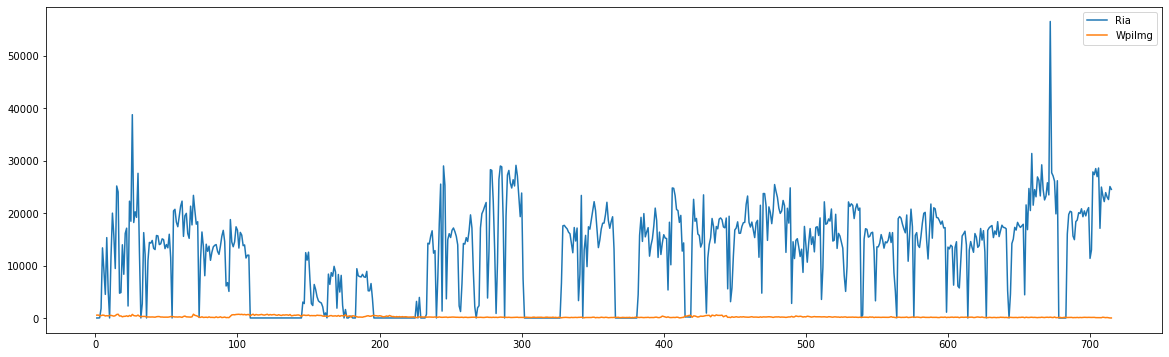

In [11]:
new.plot(figsize=(20,6))


## Drop any rows having missing values

(587, 2)


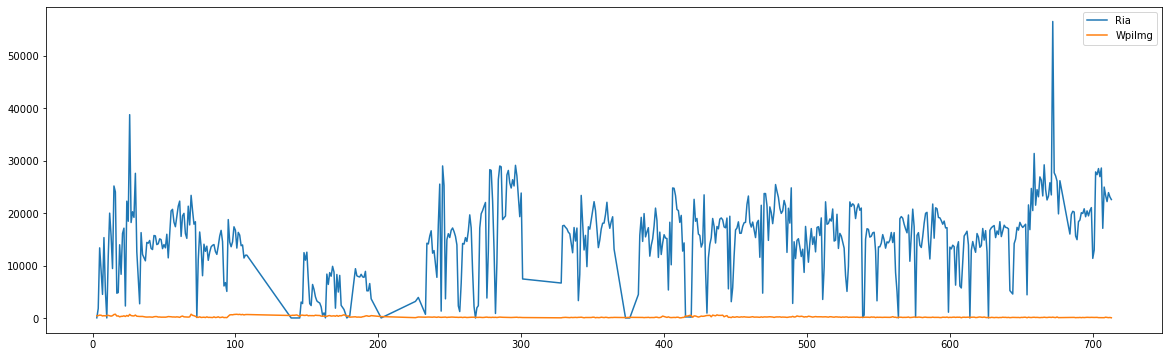

In [12]:

NoZeroData=new[~(new == 0).any(axis=1)]
print(NoZeroData.shape)
NoZeroData.plot(figsize=(20,6))

In [13]:
NoZeroData.head(100)

,Ria,WpiImg
3,32,427
4,1804,455
5,13371,543
6,9111,525
7,4497,385
...,...,...
101,13328,706
102,16322,655
103,15806,699
104,13783,617


## We can see from the above head command that we have some of the datapoints in Ria < WpiImg, so its better to keep only those data points having ria=>10(wpiImg). 
### <font color='red'>Considering that each potato can produce atleast 10 chips(retain workorders having data points having ria=>10(wpiImg))</font> 
###   <font color='blue'>ria>=10 reduces datapoints from ~700 to 537</font>

In [13]:
NoZeroData['Relevant'] = NoZeroData['Ria'] >10*NoZeroData['WpiImg']
NoZeroData.head(100)

C:\Users\80256269\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Ria,WpiImg,Relevant
3,32,427,False
4,1804,455,False
5,13371,543,True
6,9111,525,True
7,4497,385,True
...,...,...,...
101,13328,706,True
102,16322,655,True
103,15806,699,True
104,13783,617,True


(537, 3)


numpy.ndarray

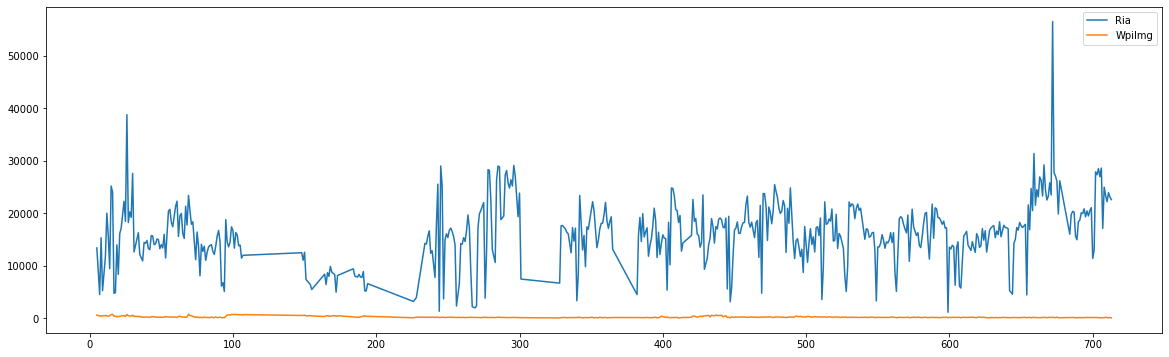

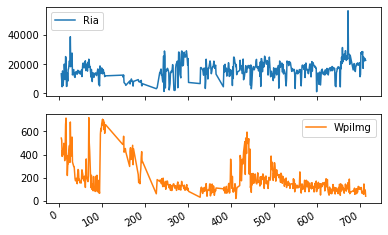

In [14]:
RelevantData=NoZeroData[NoZeroData['Relevant']==True]
RelevantData.head()
RelevantData.plot(figsize=(20,6))
print(RelevantData.shape)
RelevantData.head(100)
axes = RelevantData.plot.line(subplots=True)
#fig,axes = dataPoints.plt.line(subplots=True)
type(axes)

# <font color='red'>STEP2: Feature Engineering and Data Extraction begins here</font>
### In this step the features are extracted. I extracted total 7 features. Please refer to slides to get more overview of these features.

In [9]:
###DATA extraction Complete

def fetchFeatures(data):
    c=0
    cols=["per_Small","per_Bulky","per_Tubers_L","perLD_1","perLD_LT1pt25","perLD_125to175","perLD_GT175","per_riaL"]
    #cols=["%(L AND D)<64","%(L AND D)>64","%(L>=64&D<=64)[tubers]","%(L/D_ratio=1)[for tubers]","%(L/D_ratio=>1&<1.25)[for tubers]","%(L/D_ratio=<1.25&<1.75)","%(L/D_ratio=>1.75","%(ria>2.5inch)"]

    modelData=[]
    for e in data:
        LD_ratio=[]
        #For every truck load of data, retained the rows only if ria and wpiImg has data for the respective 
        #truckload AND ria has number of chips >= 30 times number of potatoes in wpiImg data. 
        if((e.ria.shape[0] >= 30*e.wpiImg.shape[0])==True and e.wpiImg.shape[0]>0 and e.wpiImg.shape[0]>0):
            c=c+1
            df_new = pd.DataFrame(e.wpiImg[["length","width"]], columns = ['length', 'width'])
            NoZeroData=df_new[~(df_new == 0).any(axis=1)]
       
            ##Get %ages of small, tubers and bulky 
            total=NoZeroData.shape[0]
            per_Small=(len(df_new[(df_new['length']<64.0) & (df_new['width']<64.0)])/total)*100 
            per_Bulky=(len(df_new[(df_new['length']>64.0) & (df_new['width']>64.0)])/total)*100
            per_Tubers_L=(len(df_new[(df_new['length']>=64.0) & (df_new['width']<=64.0)])/total)*100
           
        
            ##Fetching LD ratios for tubers
            Tubers=NoZeroData[(NoZeroData['length'] >=64) & (NoZeroData['width']<=64.0)] 
            Tubers['LD_ratio']=(Tubers['length']/Tubers['width']).round(2)
        
            perLD_1=round((((len(Tubers[(Tubers['LD_ratio']==1)]))/len(Tubers))*100),2)
            perLD_LT1pt25=round((((len(Tubers[(Tubers['LD_ratio']>1) & (Tubers['LD_ratio']<=1.25)]))/len(Tubers))*100),2)
            perLD_125to175=round((((len(Tubers[(Tubers['LD_ratio']>1.25)  & (Tubers['LD_ratio']<=1.75)]))/len(Tubers))*100),2)
            perLD_GT175=round((((len(Tubers[(Tubers['LD_ratio']>1.75)]))/len(Tubers))*100),2)
        
            ## Get the %age of ria for each workload >2.50
            riaL = pd.DataFrame(e.ria["length"])
            riaL.reset_index(drop=True,inplace=True)
            per_riaL=round(((len(riaL[riaL['length']>2.50])/len(riaL['length']))*100),2)
            modelData.append([per_Small,per_Bulky,per_Tubers_L,perLD_1,perLD_LT1pt25,perLD_125to175,perLD_GT175,per_riaL])
        
        
    ## Merging into one dataframe        
    df_mo = pd.DataFrame(modelData,columns=cols)
    return(df_mo)


In [10]:
# Function Call to extract feature
df_model=fetchFeatures(wodatasets.wodataLs)
print("data shape: ",df_model.shape)
df_model.head()

C:\Users\80256269\Miniconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


data shape:  (476, 8)


,per_Small,per_Bulky,per_Tubers_L,perLD_1,perLD_LT1pt25,perLD_125to175,perLD_GT175,per_riaL
0,41.002278,6.833713,52.164009,0.0,18.78,78.60,2.62,29.35
1,40.420561,7.009346,52.570093,0.0,18.67,79.11,2.22,14.49
2,39.655172,6.034483,54.310345,0.0,23.28,74.07,2.65,21.42
3,41.149773,7.261725,51.437216,0.0,17.06,80.00,2.94,18.39
4,45.111732,5.446927,49.301676,0.0,18.13,76.77,5.10,19.46


# <font color='red'>STEP3: Trying various models with regression, binarization and multi-classification technique</font>

## <font color='green'>Method1: Apply regression model without any classification(Max accuracy 15%)</font>

In [15]:
X=df_model.iloc[:,df_model.columns!='per_riaL']
y=df_model.per_riaL

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.10, random_state=42)

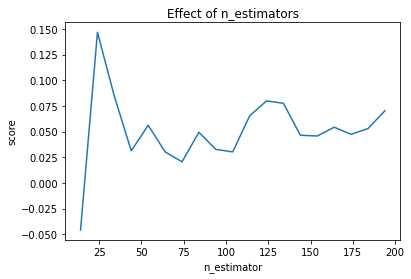

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestRegressor(n_jobs=-1)
estimators = np.arange(14, 200, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)


## <font color='green'>Method2: Binarization of data</font>
### <font color='blue'>Using binarization I split the data points into two categories, %age of chips >28% and <=28% (for chips produced having size>2.5 inches from each workorder)bar</font>



### The following code helped in checking the cut off for binarization. Since the aim was to have a balanced data, I chose 28% as the cut off

In [10]:
df_model=fetchFeatures(wodatasets.wodataLs)
df_model.shape
df_model.dtypes
binarization_threshold=28.0 ##<<<<<<<< SET THRESHOLD FOR BINARISATION HERE >>>>>>>>>>>>>>>>>>>>>
Ria=df_model[df_model.per_riaL > binarization_threshold]
print("Ratio of datapoints >",binarization_threshold,"% :",Ria.shape[0]/df_model.shape[0])
print("Total Data Points==>", len(df_model))
print("Number of datapoints in >",binarization_threshold,"% slab(1)==>",(len(df_model[df_model['per_riaL']>=binarization_threshold])))
print("Number of datapoints in <",binarization_threshold,"% slab(0)==>",len(df_model[(df_model['per_riaL']<binarization_threshold)]))

C:\Users\80256269\Miniconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Ratio of datapoints > 28.0 % : 0.5189075630252101
Total Data Points==> 476
Number of datapoints in > 28.0 % slab(1)==> 247
Number of datapoints in < 28.0 % slab(0)==> 229


In [11]:
#x=df_model[df_model['per_riaL']>=binarization_threshold]
#print(list(x['per_riaL']))

### Binarise the target column and drop the target column 'per_riaL' having %ages of large chips (having Length > 2.5 inches). Splitting data into test and train.

In [13]:
df_model=fetchFeatures(wodatasets.wodataLs)
df_model['binary_ria_gt_threshold'] = np.where(df_model['per_riaL']>binarization_threshold, '0', '1') #35%
df_model["binary_ria_gt_threshold"] = df_model["binary_ria_gt_threshold"].astype(str).astype(int)
df_model=df_model.drop(['per_riaL'],axis=1)
X=df_model.iloc[:,df_model.columns!='binary_ria_gt_threshold']
y=df_model.binary_ria_gt_threshold
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=42,shuffle=True)
#print(y == '1'.shape[0])

C:\Users\80256269\Miniconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [53]:
#X=df_model.iloc[:,df_model.columns!='binary_ria_gt_threshold']
#y=df_model.binary_ria_gt_threshold
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=42)

### Binarisation Model 1- Logistic Regression model
### Training Accuracy is 63.42% and testing accuracy is 63.71%

In [21]:
clf = LogisticRegression(random_state=0)
##Different paramters to tune the best of all
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.0001,0.01,1,5],
               'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'multi_class':['auto', 'ovr', 'multinomial']}

#Tuning the best parameters using grid search
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,cv=10, n_jobs=2,verbose=2)
grid_clf_acc.fit(X_train, y_train)
print(grid_clf_acc.best_estimator_)
print("Training Score: ",grid_clf_acc.best_score_)

y_pred=grid_clf_acc.predict(X_test)
print("Testing Score: ",accuracy_score(y_test,y_pred))

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 396 tasks      | elapsed:    4.0s


LogisticRegression(C=1, random_state=0, solver='newton-cg')
Training Score:  0.6342105263157896
Testing Score:  0.6770833333333334


[Parallel(n_jobs=2)]: Done 1500 out of 1500 | elapsed:   23.0s finished


### Binarisation Model 2 - Neural Network Sequential Model
### It gave training accuracy as 64.74% and testing accuracy as 66.67%

In [16]:
from sklearn.datasets.samples_generator import make_blobs
%matplotlib inline
import matplotlib.pyplot as plt

import os, sys
sys.path.append('/dsa/scripts')
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import scale, LabelBinarizer
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
model = tf.keras.Sequential([
    # This specifies a single neuron, and the input is 2 numbers.
    tf.keras.layers.Dense(10, input_dim=7),
    tf.keras.layers.Dense(8, input_dim=4),
    #tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()


model.compile(optimizer='rmsprop',  # this is an optimizer name, we will revisit this part later!
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.fit(X_train, y_train, epochs=380, batch_size=10)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 10)                80        
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 249
Trainable params: 249
Non-trainable params: 0
_________________________________________________________________
Train on 380 samples
Epoch 1/380
380/380 [==============================] - 1s 1ms/sample - loss: 2.2803 - accuracy: 0.4158
Epoch 2/380
380/380 [==============================] - 0s 110us/sample - loss: 1.5726 - accuracy: 0.4211
Epoch 3/380
380/380 [====

In [17]:
score = model.evaluate(X_test, y_test, batch_size=4)
score

#Testing Accuracy - accuracy: 0.6421

96/96 [==============================] - 0s 904us/sample - loss: 0.6645 - accuracy: 0.6667


[0.664523729433616, 0.6666667]

### Saved trained neural network model (with weights) to the disk.

In [18]:
#model_json = model.to_json()
#with open("binary_NNmodel.json", "w") as json_file:
#    json_file.write(model_json)

#model.save_weights("binary_NNmodel.h5")
#print("Saved model to disk")
 

### Binarisation Model 3 - Random Forest Classifier - Gridseach with cross validation was used.
### Training Score:  60.26%
### Testing Accuracy:  62.5%

In [51]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'max_depth': [2,3,4,5,10,15,20]
    
}
  
#'n_estimators': [25,50,75,100, 130, 150, 200]
Model=RandomForestClassifier()

clf2 = GridSearchCV(estimator=Model,cv=10, n_jobs=2,param_grid=param_grid,verbose=2)
clf2.fit(X_train, y_train)
print("#### RandomForest ####")
print(clf2.best_estimator_)
print("Training Score: ",clf2.best_score_)

y_pred=clf2.predict(X_test)
print("Testing Score: ",accuracy_score(y_test,y_pred))

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    8.8s finished


#### RandomForest ####
RandomForestClassifier(max_depth=2)
Training Score:  0.6026315789473684
Testing Score:  0.625


In [19]:
#import joblib
#joblib.dump(clf2,'Binary_RandomForestClassifier.pkl') #'RamdomForestWith_66_per_Accuracy.pkl')

### Binarisation Model 4 - XG boost Classifier - Gridseach with cross validation=10 was used.
### Training Score:  64.21%
### Testing Accuracy:  66.67%

### Note: XGBoost model is usually slow than other models because it involves gradient descent. And depending upon what is the learning rate is set, the slowness will prevail.

In [74]:
from numpy import loadtxt
from xgboost import XGBClassifier

params = {
        'min_child_weight': [1, 4,5, 10],
        'gamma': [0.5,0.1, 1, 1.5, 2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'booster':['dart','gbtree','gblinear']
        }
#params={'booster':['dart','gbtree','gblinear']}

model=XGBClassifier()#sampling_method='gradient_based')
xgb=GridSearchCV(estimator=model, cv=10,n_jobs=2,param_grid=params,verbose=2)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(xgb.best_estimator_)
print("Training Score: ",xgb.best_score_)
print("Testing Accuracy: ",accuracy)



Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done 286 tasks      | elapsed:   13.5s
[Parallel(n_jobs=2)]: Done 1078 tasks      | elapsed:   37.9s


[12:13:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colsample_bytree, gamma, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.6, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.5, max_delta_step=None, max_depth=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=None,
              random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
              subsample=0.6, tree_method=None, validate_para

[Parallel(n_jobs=2)]: Done 2700 out of 2700 | elapsed:  1.0min finished


## <font color='green'>Method3: With Multi-Classification </font>

#### Fetching the number of data points in the four classes


C:\Users\80256269\Miniconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total Data Points==> 476
Number of datapoints in 0-10% slab==> 6
Number of datapoints in 10-20% slab==> 46
Number of datapoints in 20-30% slab==> 229
Number of datapoints in 30-40% slab==> 195
Number of datapoints in >40% slab==> 0


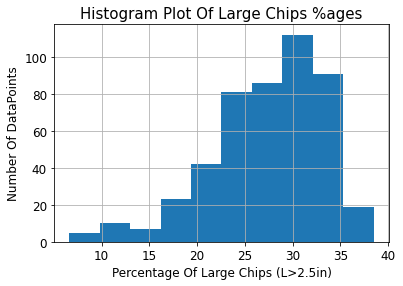

In [20]:
df_model=fetchFeatures(wodatasets.wodataLs)
(len(df_model[df_model['per_riaL']<10])/len(df_model))*100
len(df_model[df_model['per_riaL']<10])
print("Total Data Points==>", len(df_model))
print("Number of datapoints in 0-10% slab==>",(len(df_model[df_model['per_riaL']<10])))
print("Number of datapoints in 10-20% slab==>",len(df_model[(df_model['per_riaL']>=10) & (df_model['per_riaL']<20)]))
print("Number of datapoints in 20-30% slab==>",len(df_model[(df_model['per_riaL']>=20) & (df_model['per_riaL']<30)]))#/len(df_model))*100)
print("Number of datapoints in 30-40% slab==>",len(df_model[(df_model['per_riaL']>=30) & (df_model['per_riaL']<40)]))#/len(df_model))*100)
print("Number of datapoints in >40% slab==>",(len(df_model[df_model['per_riaL']>40])))#/len(df_model))*100)

df_model['per_riaL'].hist()

plt.xlabel('Percentage Of Large Chips (L>2.5in)',fontsize=12)
plt.ylabel('Number Of DataPoints',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.ylabel('Frequency',fontsize=12)
plt.title('Histogram Plot Of Large Chips %ages',fontsize=15)
plt.show()



### Creating multi-classes (In current case 4 classes, 0-10%,10-20%,20-30%,30-40%) 

In [21]:
df_model['ria']=pd.cut(df_model['per_riaL'], bins=[0, 10, 20, 30,40], include_lowest=True,\
                       labels=["0-10", "10-20","20-30","30-40" ])
df_model.head()

,per_Small,per_Bulky,per_Tubers_L,perLD_1,perLD_LT1pt25,perLD_125to175,perLD_GT175,per_riaL,ria
0,41.002278,6.833713,52.164009,0.0,18.78,78.60,2.62,29.35,20-30
1,40.420561,7.009346,52.570093,0.0,18.67,79.11,2.22,14.49,10-20
2,39.655172,6.034483,54.310345,0.0,23.28,74.07,2.65,21.42,20-30
3,41.149773,7.261725,51.437216,0.0,17.06,80.00,2.94,18.39,10-20
4,45.111732,5.446927,49.301676,0.0,18.13,76.77,5.10,19.46,10-20


In [79]:
print("Total Data Points==>", len(df_model))
print("Number of datapoints in 0-25% slab==>",(len(df_model[df_model['per_riaL']<25])))
#print("Number of datapoints in 10-20% slab==>",len(df_model[(df_model['per_riaL']>=10) & (df_model['per_riaL']<20)]))
print("Number of datapoints in 25-30% slab==>",len(df_model[(df_model['per_riaL']>=25) & (df_model['per_riaL']<30)]))#/len(df_model))*100)
print("Number of datapoints in >30% slab==>",len(df_model[(df_model['per_riaL']>=30)]))#/len(df_model))*100)

Total Data Points==> 476
Number of datapoints in 0-25% slab==> 145
Number of datapoints in 25-30% slab==> 136
Number of datapoints in >30% slab==> 195


In [ ]:
#To classifiy into 3 categories
#df_model['ria']=pd.cut(df_model['per_riaL'], bins=[0, 25,30,100], include_lowest=True,labels=["0-25", "25-30",">30"])
#df_model.head(100)

### Dropping the chips %age column(having Length >2.5 inches) and retaining the multi-class column as target column

In [22]:
df_model=df_model.drop(['per_riaL'],axis=1)
X=df_model.iloc[:,df_model.columns!='ria']
y=df_model.ria
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42)
#print(y == '1'.shape[0])

## Multiclassification Model 1 - Logistic regression (with grid search alongwith cross validation)
### Training Accuracy:  52.65% and Testing Accuracy:  56.30%



In [96]:
clf = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.0001,0.01,0.1,1,5]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,cv=10, n_jobs=2,verbose=2)
grid_clf_acc.fit(X_train, y_train)
print(grid_clf_acc.best_estimator_)
print("Training Score: ",grid_clf_acc.best_score_)


#print(scores)
#clf.fit(X_train,y_train)
y_pred=grid_clf_acc.predict(X_test)
print("Testing Score: ",accuracy_score(y_test,y_pred))

Fitting 10 folds for each of 12 candidates, totalling 120 fits


C:\Users\80256269\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 111 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:    1.1s finished


LogisticRegression(C=0.1)
Training Score:  0.5265079365079366
Testing Score:  0.5630252100840336


C:\Users\80256269\Miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Multiclassification Model 2 - RandomForest Classifier with grid search and cross validation=10)

### Training Accuracy:  50.44% and Testing Accuracy:  48.74%



In [118]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
#from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report



param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30, 40],
    'n_estimators': [25,50,70,100, 130, 150, 200]
}


Model=RandomForestClassifier()#,class_weight=class_weight)
#scores = cross_val_score(clf, X_train,y_train, cv=5)

clf2 = GridSearchCV(estimator=Model, cv=10, n_jobs=2,param_grid=param_grid,verbose=2)
clf2.fit(X_train, y_train)
print("Training Score: ",clf2.best_score_)
print(clf2.best_estimator_)

#print(scores)
#clf.fit(X_train,y_train)
y_pred=clf2.predict(X_test)
print("Testing Score: ",accuracy_score(y_test,y_pred))

Fitting 10 folds for each of 28 candidates, totalling 280 fits


C:\Users\80256269\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 128 tasks      | elapsed:   11.3s


Training Score:  0.5071428571428571
RandomForestClassifier(max_depth=10, n_estimators=50)
Testing Score:  0.48739495798319327


[Parallel(n_jobs=2)]: Done 280 out of 280 | elapsed:   29.7s finished


# Multiclassification Model 3 - XGBoost classifier (with grid search and cross validation=10)
### Training accuracy as 52.38% and testing accuracy as 52.94

In [107]:
from numpy import loadtxt
from xgboost import XGBClassifier


params={'booster':['dart','gbtree','gblinear']}

model=XGBClassifier(sampling_method='gradient_based')
xgb=GridSearchCV(estimator=model, cv=10, n_jobs=2,param_grid=params,verbose=2)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(xgb.best_estimator_)
print("Training Score: ",xgb.best_score_)
print("Testing Accuracy: ",accuracy)



Fitting 10 folds for each of 3 candidates, totalling 30 fits


C:\Users\80256269\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[11:37:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sampling_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.5, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=None,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=0, sampling_method='gradient_based',
              scale_pos_weight=None,

[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    2.3s finished
